In [1]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon

import re,os
import numpy as np
import matplotlib.pyplot as plt

import kml2geojson
import json

In [2]:
pd.options.display.max_columns = None

### S3 data pull

In [3]:
bucket = "s3://secondmeasure-dev-at-foundational-data/hakso/detroit/"
neighborhood_file = f"{bucket}Current_City_of_Detroit_Neighborhoods.geojson"
greenlight_file = f"{bucket}Project_Green_Light_Locations.geojson"

In [4]:
neighborhood_geo_df = gpd.read_file(neighborhood_file)
greenlight_geo_df = gpd.read_file(greenlight_file)

In [5]:
neighborhood_geo_df.head()

,OBJECTID,council_district,nhood_num,nhood_name,Website,geometry
0,1,4,103,West End,https://theneighborhoods.org/neighborhoods/wes...,"POLYGON ((-82.99152 42.38439, -82.99249 42.384..."
1,2,4,105,Chandler Park,https://theneighborhoods.org/neighborhoods/cha...,"POLYGON ((-82.97585 42.38933, -82.97603 42.389..."
2,3,4,100,Riverbend,https://theneighborhoods.org/neighborhoods/riv...,"POLYGON ((-82.96784 42.38369, -82.96783 42.383..."
3,4,4,101,Jefferson Chalmers,https://theneighborhoods.org/neighborhoods/jef...,"POLYGON ((-82.95141 42.35503, -82.95292 42.354..."
4,5,1,29,Riverdale,https://theneighborhoods.org/neighborhoods/riv...,"POLYGON ((-83.25748 42.41460, -83.25729 42.411..."


In [6]:
greenlight_geo_df.head()

,address,business_name,business_type,precinct,live_date,ObjectId,geometry
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01T05:00:00+00:00,1,POINT (-83.19918 42.40172)
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01T05:00:00+00:00,2,POINT (-83.15984 42.41718)
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01T05:00:00+00:00,3,POINT (-83.19764 42.38679)
3,11603 E 7 Mile Rd,Sunoco,Retail,9,2016-01-01T05:00:00+00:00,4,POINT (-83.00422 42.43468)
4,10601 E Outer Dr,BP,Retail,9,2016-01-01T05:00:00+00:00,5,POINT (-82.95968 42.40584)


### Data Verification

##### Empty and NaN check

In [7]:
print(neighborhood_geo_df['geometry'].is_empty.sum())
print(greenlight_geo_df['geometry'].is_empty.sum())
print(neighborhood_geo_df['geometry'].isna().sum())
print(greenlight_geo_df['geometry'].isna().sum())

0
0
0
0


In [8]:
#greenlight_geo_df['geometry'][1] = np.NaN

### Map locations to neighborhoods

<AxesSubplot:>

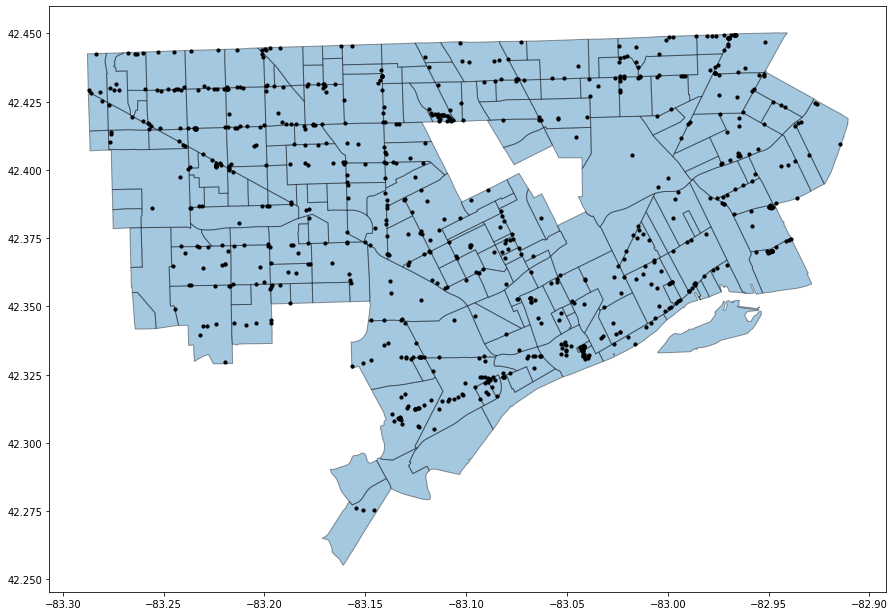

In [9]:
fig,ax = plt.subplots(figsize = (15,15))
neighborhood_geo_df.plot(ax = ax, alpha=0.4, edgecolor='black')
greenlight_geo_df.plot(ax = ax, markersize=10, color = "black")

### Greenlight Data Exploration

In [10]:
greenlight_geo_df.head()

,address,business_name,business_type,precinct,live_date,ObjectId,geometry
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01T05:00:00+00:00,1,POINT (-83.19918 42.40172)
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01T05:00:00+00:00,2,POINT (-83.15984 42.41718)
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01T05:00:00+00:00,3,POINT (-83.19764 42.38679)
3,11603 E 7 Mile Rd,Sunoco,Retail,9,2016-01-01T05:00:00+00:00,4,POINT (-83.00422 42.43468)
4,10601 E Outer Dr,BP,Retail,9,2016-01-01T05:00:00+00:00,5,POINT (-82.95968 42.40584)


#### Distance calculation

In [11]:
from scipy.spatial import cKDTree

In [12]:
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=[2])
    gdB_nearest = gdB.iloc[idx.flatten()].drop(columns="geometry").reset_index(drop=True)
    gdB_nearest.columns = [str(col) + '_neighbor' for col in gdB_nearest.columns]
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist.flatten()*111139, name='dist_meters')
        ], 
        axis=1)

    return gdf

In [13]:
greenlight_geo_df = ckdnearest(greenlight_geo_df, greenlight_geo_df)

In [18]:
greenlight_geo_df.sort_values('dist_meters', ascending=True)

,address,business_name,business_type,precinct,live_date,ObjectId,geometry,address_neighbor,business_name_neighbor,business_type_neighbor,precinct_neighbor,live_date_neighbor,ObjectId_neighbor,dist_meters
330,8701 W Vernor Hwy,WAY Academy,Services,4,2018-07-30T04:00:00+00:00,331,POINT (-83.13271 42.30904),"8701 W Vernor Hwy, Suite 301",Living Arts,Services,4,2018-07-30T04:00:00+00:00,330,0.000000
329,"8701 W Vernor Hwy, Suite 301",Living Arts,Services,4,2018-07-30T04:00:00+00:00,330,POINT (-83.13271 42.30904),"8701 W Vernor Hwy, Suite 301",Living Arts,Services,4,2018-07-30T04:00:00+00:00,330,0.000000
274,"8701 W Vernor Hwy, Suite 102",COMPAS,Services,4,2018-04-04T04:00:00+00:00,275,POINT (-83.13271 42.30904),"8701 W Vernor Hwy, Suite 301",Living Arts,Services,4,2018-07-30T04:00:00+00:00,330,0.000000
589,"8044 Kercheval St, Unit 1A",Village Parlor,Services,7,2019-10-30T04:00:00+00:00,590,POINT (-82.99895 42.35853),"8044 Kercheval, Unit 1B",Marrow,Retail,7,2018-12-07T05:00:00+00:00,424,2.688094
423,"8044 Kercheval, Unit 1B",Marrow,Retail,7,2018-12-07T05:00:00+00:00,424,POINT (-82.99892 42.35854),"8044 Kercheval St, Unit 1A",Village Parlor,Services,7,2019-10-30T04:00:00+00:00,590,2.688094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,18430 Ford Rd,Wendy's,Retail,6,2017-07-26T04:00:00+00:00,169,POINT (-83.21972 42.32946),18750 W Warren Ave,Ice Liquor,Retail,6,2019-10-09T04:00:00+00:00,572,1640.696876
714,1900 E McNichols Rd,BP,Retail,11,2021-02-05T05:00:00+00:00,715,POINT (-83.08162 42.41821),1700 E 7 Mile Rd,Coin-O-Matic,Services,11,2018-03-13T04:00:00+00:00,266,1658.786029
101,18201 Mack Ave,McDonald's,Retail,5,2017-03-20T04:00:00+00:00,102,POINT (-82.91449 42.40945),17040 E Warren Ave,Marathon,Retail,5,2019-03-28T04:00:00+00:00,481,1766.757845
500,8301 Lynch Rd,Premier Group Associates,Services,11,2019-05-10T04:00:00+00:00,501,POINT (-83.01791 42.40532),9963 Gratiot Ave,Prince Liquor,Retail,7,2019-05-24T04:00:00+00:00,509,1911.505005
